# Part 0: Import Statements

In [115]:
# import stats + sklearn classifiers + regressors
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

!python -m pip install pydot
import pydot
from sklearn import *

from sklearn.preprocessing import StandardScaler
from matplotlib import*
import matplotlib.pyplot as plt
from matplotlib.cm import register_cmap
from scipy import stats
from sklearn.decomposition import PCA as sklearnPCA


# Part 1: Read and parse data

In [116]:
# read in data and get the size of the data set
X = pd.read_csv('drug_properties_final.csv', header=0, usecols=range(1,16))
print(X.shape)


# nsamples, nfts = X.shape
# # print(nsamples)
# # print(nfts)
# # print(X)

(1784, 15)


In [117]:
# get the names of the drugs we are looking at
drugs = pd.read_csv('drug_name_list_final.csv', header=0, usecols=range(1,2))
#drugs

In [118]:
# there are more drugs that have max response and auc data since not all drugs were 
# accessible in pubchem- so load that bigger set of drugs
drugs_with_resp_auc_data = pd.read_csv('drugs.csv', usecols = range(1,2))
#drugs_with_resp_auc_data

In [119]:
# get the proper indexes from the set of all drugs to map to the pubchem drugs 
indexes = []
counter = 0
for drug in drugs_with_resp_auc_data.iloc[:,0]:
    if drug in list(drugs.iloc[:,0]):
        indexes.append(counter)
    counter = counter + 1

In [120]:
# get values for auc
auc_values = pd.read_csv('auc.csv')
auc_values = auc_values.iloc[:,1:7]
print(auc_values.head(5))

# get values for max resp
maxresp_values = pd.read_csv('max_resp.csv')
maxresp_values = maxresp_values.iloc[:,1:7]
print(maxresp_values.head(5))

         0        1        2        3        4        5
0  428.792  460.119  277.164  443.183  408.479  408.348
1  466.491  494.689  477.969  580.252  445.541  490.083
2  413.997  261.922  438.649  360.282  417.510  322.348
3  473.658  514.225  391.226  472.357  455.033  483.530
4  499.085  454.862  284.317  498.955  490.830  436.067
         0        1       2        3       4        5
0   31.627   50.723  39.010   62.477  53.749   73.943
1  104.528  106.693  94.311  120.259  79.373  105.277
2   94.854   15.955  91.379   82.129  87.158   66.432
3   63.828   74.488  49.955  101.986  88.269   92.542
4    5.796    8.253  14.334   89.583  72.228   47.565


In [121]:
# get the re-indexed set of drugs, auc values, and max resp
final_drugs = drugs_with_resp_auc_data.iloc[indexes,0]


final_auc = auc_values.iloc[indexes,:]
#aaron - reset index to keep drug_ids
final_auc = final_auc.reset_index()


final_maxresp = maxresp_values.iloc[indexes,:]
#aaron - reset index to keep drug_ids
final_maxresp = final_maxresp.reset_index()

# print(final_maxresp)
# final_auc
# final_drugs_ids = list(final_drugs.keys())
# for item in final_drugs_ids:
#     int(item)

#set index of drug ids for X
X['index'] = list(final_drugs.keys())


# Remove NaNs

In [122]:
# fix inf, nan values, and values exceeding the max
X[X==np.inf]=np.nan
np.where(X.values >= np.finfo(np.float32).max)
X = np.nan_to_num(X)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until


In [123]:
# check data to make sure we got rid of inf, nan, and max values
print(sum(np.isnan(X)))
print(sum(X > 10000))
print(sum(np.isinf(X)))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [124]:
# and remove the nans in the auc data frame
final_auc = np.nan_to_num(final_auc)
print(sum(np.isnan(final_auc)))

[0 0 0 0 0 0 0]


In [125]:
# and remove the nans in the max resp data frame
final_maxresp = np.nan_to_num(final_maxresp)
print(sum(np.isnan(final_maxresp)))

[0 0 0 0 0 0 0]


In [126]:
# get column names (names of drug features)
fts = pd.read_csv('val_names.csv')
fts = fts.iloc[:,1]
print(fts)

0         atom_stereo_count
1         bond_stereo_count
2                    charge
3                complexity
4       covalent_unit_count
5                exact_mass
6     h_bond_acceptor_count
7        h_bond_donor_count
8          heavy_atom_count
9        isotope_atom_count
10         molecular_weight
11        monoisotopic_mass
12       rotable_bond_count
13                     tpsa
14                    xlogp
Name: 0, dtype: object


# Part 2: Exploration

In [127]:
#fix scientific notation printing of arrays

np.set_printoptions(suppress=True)

In [128]:
# plt.scatter(X[:,3], final_auc[:,0], color = 'blue', label = lines[0])
# plt.scatter(X[:,3], final_auc[:,1], color = 'red', label = lines[1])
# plt.scatter(X[:,3], final_auc[:,2], color = 'orange', label = lines[2])
# plt.scatter(X[:,3], final_auc[:,3], color = 'green', label = lines[3])
# plt.scatter(X[:,3], final_auc[:,4], color = 'purple', label = lines[4])
# plt.scatter(X[:,3], final_auc[:,5], color = 'pink', label = lines[5])
# plt.legend()
# plt.xlabel('Complexity')
# plt.ylabel('AUC')

# merge all cleaned arrays to new df where drug id is index

In [130]:
drug_measures = pd.DataFrame({'drug_id': (X[:,15])})
# i=0
# for ft in list(fts.values):
#     drug_measures[ft] = X[:,i]
#     i+=1
# drug_measures.astype('int').dtypes


drug_measures['drug_name'] = final_drugs.values
drug_measures.astype({'drug_id': 'int'})


cell_lines = ['HS01', 'HS12', 'MS02', 'Syn1', 'Syn5', 'Syn6']

#add data from final auc
i= 1
for line in cell_lines:
    drug_measures[line+"_final_auc"] = final_auc[:,i]
    i+1
    
#add data from maxresp
i= 1
for line in cell_lines:
    drug_measures[line+"_maxresp"] = final_maxresp[:,i]
    i+1
    
 
avg_maxresp = []
avg_final_auc = []
for index, row in drug_measures.iterrows():
    avg_maxresp.append(np.average([row['HS01_maxresp'],row['HS12_maxresp'],row['MS02_maxresp'],row['Syn1_maxresp'], row['Syn5_maxresp'], row['Syn6_maxresp']]))
    
    avg_final_auc.append(np.average([row['HS01_final_auc'],row['HS12_final_auc'],row['MS02_final_auc'],row['Syn1_final_auc'], \
    row['Syn5_final_auc'], row['Syn6_final_auc']]))
    
    
drug_measures['avg_final_auc'] =  pd.Series(avg_final_auc, index=drug_measures.index)  
drug_measures['avg_maxresp'] =  pd.Series(avg_maxresp, index=drug_measures.index)    
    



# # # # fts.values

# # # # final_drugs
drug_measures

,drug_id,drug_name,HS01_final_auc,HS12_final_auc,MS02_final_auc,Syn1_final_auc,Syn5_final_auc,Syn6_final_auc,HS01_maxresp,HS12_maxresp,MS02_maxresp,Syn1_maxresp,Syn5_maxresp,Syn6_maxresp,avg_final_auc,avg_maxresp
0,1.0,(+)-Usniacin,466.491,466.491,466.491,466.491,466.491,466.491,104.528,104.528,104.528,104.528,104.528,104.528,466.491,104.528
1,2.0,"(+-)-7-(3,5,6-trimethyl-1,4-benzoquinon-2-yl)-...",413.997,413.997,413.997,413.997,413.997,413.997,94.854,94.854,94.854,94.854,94.854,94.854,413.997,94.854
2,3.0,(-)-Blebbistatin,473.658,473.658,473.658,473.658,473.658,473.658,63.828,63.828,63.828,63.828,63.828,63.828,473.658,63.828
3,4.0,(-)-Gossypol,499.085,499.085,499.085,499.085,499.085,499.085,5.796,5.796,5.796,5.796,5.796,5.796,499.085,5.796
4,5.0,(-)-Indolactam V,439.192,439.192,439.192,439.192,439.192,439.192,90.842,90.842,90.842,90.842,90.842,90.842,439.192,90.842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779,1900.0,methyl jasmonate,494.093,494.093,494.093,494.093,494.093,494.093,98.347,98.347,98.347,98.347,98.347,98.347,494.093,98.347
1780,1901.0,NaN,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1781,1902.0,nor-Binaltorphimine,451.037,451.037,451.037,451.037,451.037,451.037,104.880,104.880,104.880,104.880,104.880,104.880,451.037,104.880
1782,1903.0,purmorphamine,458.061,458.061,458.061,458.061,458.061,458.061,95.284,95.284,95.284,95.284,95.284,95.284,458.061,95.284


# cluster on each parameter for each cell line

[[   2.125         0.19565217    0.          772.60869565    1.1888587
   495.6482877     7.35869565    2.43342391   34.73913043    0.
   496.1572962   495.62657574    6.80163043  112.96086957    3.1048913
   433.91504212  433.91504212  433.91504212  433.91504212  433.91504212
   433.91504212   60.33931929   60.33931929   60.33931929   60.33931929
    60.33931929   60.33931929  433.91504212   60.33931929]
 [   1.04757085    0.11234818    0.00101215  413.97520243    1.16497976
   312.40445965    4.62044534    1.92004049   21.76923077    0.
   312.79241093  312.39435039    3.95850202   78.85293522    1.91933198
   485.39129656  485.39129656  485.39129656  485.39129656  485.39129656
   485.39129656   84.0092915    84.0092915    84.0092915    84.0092915
    84.0092915    84.0092915   485.39129656   84.0092915 ]
 [  11.95          1.2          -0.         1849.21666667    1.46666667
   999.36503238   16.05          7.08333333   70.21666667    0.
  1000.11166667  999.36503238   13.66666667  

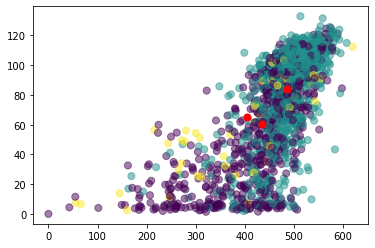

In [45]:
drug_measures_num = drug_measures.drop(['drug_id', 'drug_name'], axis=1)

kmeans = KMeans(n_clusters=3).fit(drug_measures_num)
centroids = kmeans.cluster_centers_
print(centroids)



plt.scatter(drug_measures_num['avg_final_auc'], drug_measures_num['avg_maxresp'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 27], centroids[:, 28], c='red', s=50)

# cluster on average auc and average max response for each cell line

[50.69698974 19.90142169 95.21531849]


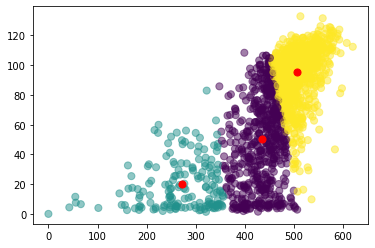

In [66]:
drug_measures_outputs = drug_measures[['avg_final_auc','avg_maxresp']]

# print(drug_measures_outputs)

kmeans = KMeans(n_clusters=3).fit(drug_measures_outputs)
centroids = kmeans.cluster_centers_
print(centroids[:,1])



plt.scatter(drug_measures_num['avg_final_auc'], drug_measures_num['avg_maxresp'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)

# make a function to pick a feature and where they are in each cluster

In [103]:
#function to plot based on feature

#make a function to pick a feature and where they are in each cluster
#vertical placing is just to see lines due to them overlapping

def feature_plot(feature, df):
    clust_turq= []
    clust_yel = []
    clust_purp = []
    y_turq = []
    y_yel = []
    y_purp = []

    for index, row in df.iterrows():
        if (0 < row['avg_final_auc'] < 360) and (0 < row['avg_maxresp'] < 85):
            clust_turq.append([row['avg_final_auc'],row['avg_maxresp'], row[feature]])
            y_turq.append(0)
            continue

        if ( 615 > row['avg_final_auc'] > 510) and (6 < row['avg_maxresp'] < 135):
            clust_yel.append([row['avg_final_auc'],row['avg_maxresp'], row[feature]])
            y_yel.append(1)
            continue

        if ( 370 < row['avg_final_auc'] < 510) and (0 < row['avg_maxresp'] < 113):
            clust_purp.append([row['avg_final_auc'],row['avg_maxresp'], row[feature]])
            y_purp.append(2)
            continue
            
    clust_turq = numpy.array(clust_turq)
    clust_yel = numpy.array(clust_yel)
    clust_purp = numpy.array(clust_purp)
    
            

        
    plt.plot(clust_turq[:, 2],y_turq, c='turquoise')    
    plt.plot(clust_yel[:, 2],y_yel, c='orange')  
    plt.plot(clust_purp[:, 2],y_purp, c='purple')  
    
    
    

# 3                complexity

# 13                     tpsa
# 14                    xlogp



    

In [ ]:
plot for features 

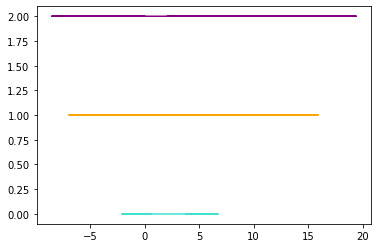

In [104]:
#see range of xlogp values for each cluster (veritical axis just used for seperation)
feature_plot('xlogp',drug_measures)

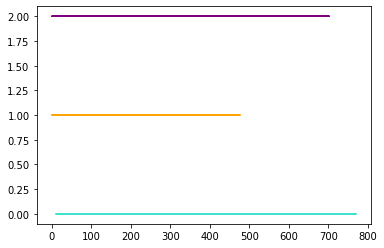

In [99]:
#see range of tpsa values for each cluster (veritical axis just used for seperation)
feature_plot('tpsa',drug_measures)

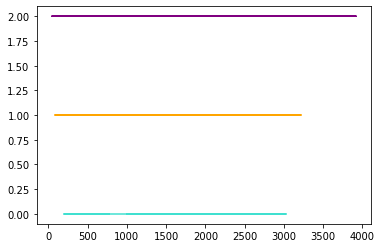

In [102]:
#see range of complexity values for each cluster (veritical axis just used for seperation)
feature_plot('complexity',drug_measures)